# Feature Engineering 

In [1]:
import pandas as pd
import numpy as np

from math import sqrt
import regex as re
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick 
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter, FuncFormatter
%matplotlib inline
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)
from cycler import cycler

import seaborn as sns
sns.set()

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from textacy import preprocessing
import textacy
from nltk.corpus import stopwords
from nltk.stem import *

import spacy
nlp = spacy.load('en_core_web_sm')

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from  sklearn.metrics  import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
# for one hot encoding with sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import VarianceThreshold

# for the Q-Q plots
import scipy.stats as stats


# for one hot encoding with feature-engine
from feature_engine.encoding import OneHotEncoder as fe_OneHotEncoder

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import roc_auc_score, r2_score, mean_squared_error
# environment settings
pd.set_option('display.max_column',None)
pd.set_option('display.max_rows',None)

## Imputing missing values
All missing values that are imputed in some way /mean, median, mode, other methods/ should be done separately for the training and the test set, in order to avoid data leakage.
Cardinality check, discretization and binning are taken into account

In [2]:
listings = pd.read_pickle('/Users/asyagadzhalova/Documents/GitHub/Boston-Airbnb-data/src/data/processed/listings.pkl')

In [3]:
listings.drop('id',axis=1,inplace=True)

In [4]:
# plot the histograms to have a quick look at the variable distribution
# histogram and Q-Q plots

def diagnostic_plots(df, variable):
    
    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable
    
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist(bins=30)

    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)

    plt.show()

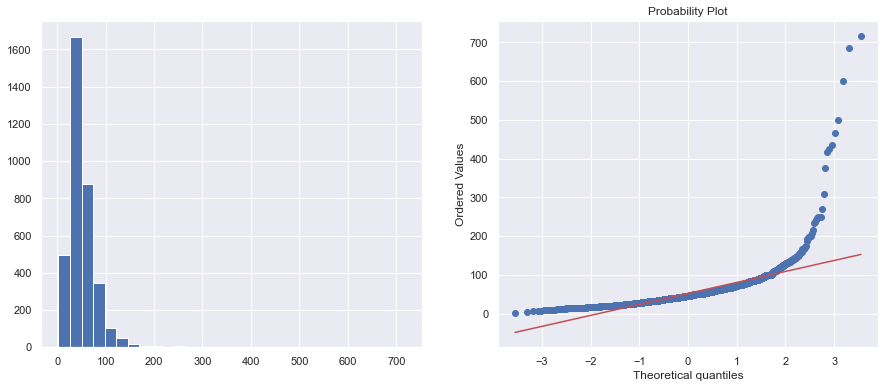

In [5]:
diagnostic_plots(listings,'price_per_person')

In [50]:
listings['price_per_person_log'] = np.log(listings['price_per_person'])

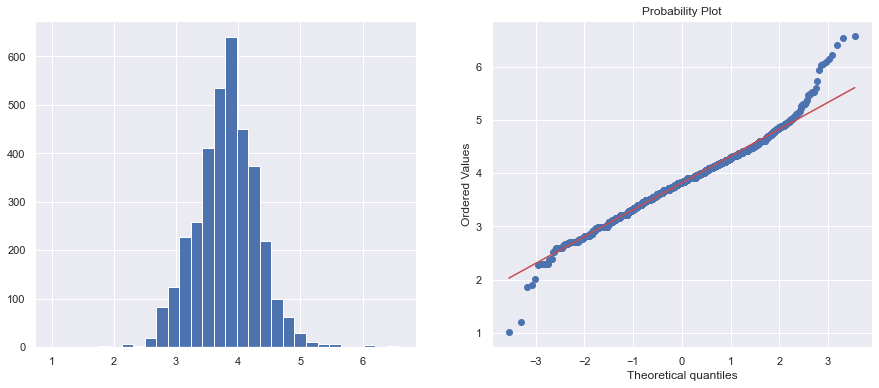

In [51]:
diagnostic_plots(listings,'price_per_person_log')

In [156]:
listings['security_deposit_log'] = (listings['security_deposit']**2)

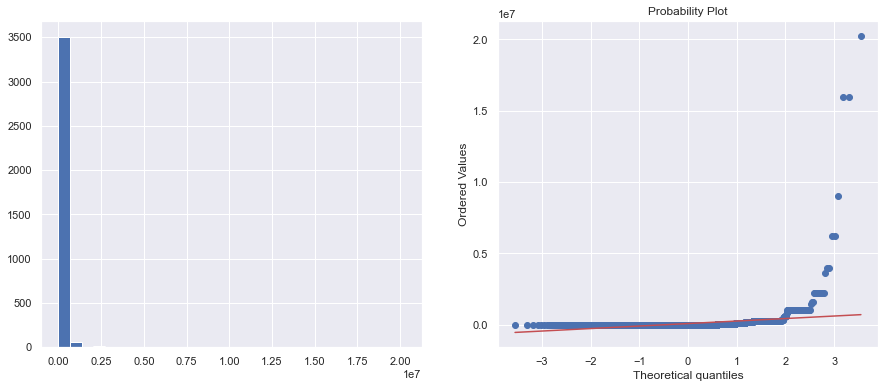

In [157]:
diagnostic_plots(listings,'security_deposit_log')

In [6]:
df = listings.drop(['price_per_person'],axis=1)
y = listings['price_per_person'].copy()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df, # just the features
                                                    y, # the target
                                                    test_size=0.3, # the percentage of obs in the test set
                                                    random_state=42) # for reproducibility

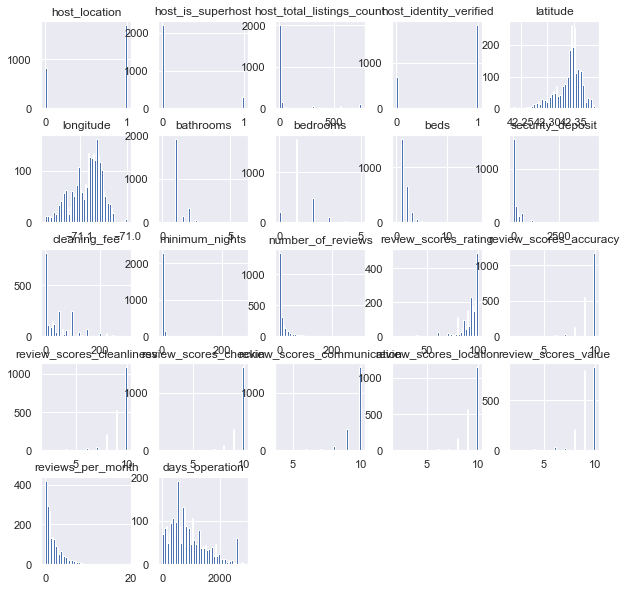

In [8]:
X_train.hist(bins=50, figsize=(10,10))
plt.show()

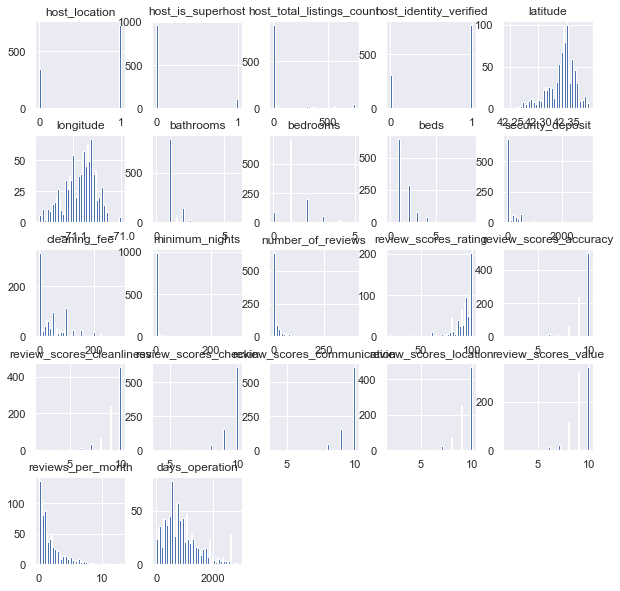

In [9]:
X_test.hist(bins=50, figsize=(10,10))
plt.show()

In [10]:
listings.isna().sum().sort_values(ascending = False)

review_scores_accuracy         823
review_scores_location         822
review_scores_value            821
review_scores_checkin          820
review_scores_communication    818
review_scores_cleanliness      818
review_scores_rating           813
reviews_per_month              756
host_response_time             471
host_acceptance_rate           471
host_response_rate             471
bathrooms                       14
bedrooms                        10
beds                             9
property_type                    3
city                             2
cancellation_policy              0
number_of_reviews                0
days_operation                   0
host_location                    0
bed_type                         0
minimum_nights                   0
cleaning_fee                     0
security_deposit                 0
amenities                        0
room_type                        0
longitude                        0
latitude                         0
neighbourhood_cleans

In [11]:
#We will use missing value category for the review columns NAs, since the proportion of the missing data is huge - 20% of the total dataset
missing_value = ['reviews_per_month','review_scores_location',
                          'review_scores_value','review_scores_checkin','review_scores_cleanliness',
                          'review_scores_communication','review_scores_rating','review_scores_accuracy',
                'host_response_time']

for col in missing_value:
    X_train[col].fillna(-1,inplace=True)
    X_test[col].fillna(-1,inplace=True)

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


#### Host response rate and acceptance rate also have around 10% of missing data -> it is quite. So I will use a missing category to impute for the missing values, and discretization&binning

In [12]:
cols = ['host_response_rate','host_acceptance_rate']
for col in cols:
    X_train[col] = X_train[col].str.replace('%','')
    X_train[col] = pd.to_numeric(X_train[col])
    X_test[col] = X_test[col].str.replace('%','')
    X_test[col] = pd.to_numeric(X_test[col])

/var/folders/xx/52xcnk8x57b6lb5ws1h4mj2c0000gn/T/ipykernel_18589/3168245722.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = X_train[col].str.replace('%','')
/var/folders/xx/52xcnk8x57b6lb5ws1h4mj2c0000gn/T/ipykernel_18589/3168245722.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = pd.to_numeric(X_train[col])
/var/folders/xx/52xcnk8x57b6lb5ws1h4mj2c0000gn/T/ipykernel_18589/3168245722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [13]:
X_train['host_response_rate'].fillna(-1,inplace=True)
X_train['host_acceptance_rate'].fillna(-1,inplace=True)

X_test['host_response_rate'].fillna(-1,inplace=True)
X_test['host_acceptance_rate'].fillna(-1,inplace=True)

In [14]:
# bucket boundaries
buckets = [-1, 0, 20, 40, 50, 70, 90,100]
X_train['response_rate_buckets'] = pd.cut(X_train['host_response_rate'], bins=buckets, include_lowest=True)
X_test['response_rate_buckets'] = pd.cut(X_test['host_response_rate'], bins=buckets, include_lowest=True)

/var/folders/xx/52xcnk8x57b6lb5ws1h4mj2c0000gn/T/ipykernel_18589/539011250.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['response_rate_buckets'] = pd.cut(X_train['host_response_rate'], bins=buckets, include_lowest=True)
/var/folders/xx/52xcnk8x57b6lb5ws1h4mj2c0000gn/T/ipykernel_18589/539011250.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['response_rate_buckets'] = pd.cut(X_test['host_response_rate'], bins=buckets, include_lowest=True)


In [15]:
# bucket 2 boundaries
buckets2 = [-1, 0, 20, 40, 50, 70, 90,100]
X_train['accept_rate_buckets'] = pd.cut(X_train['host_acceptance_rate'], bins=buckets, include_lowest=True)
X_test['accept_rate_buckets'] = pd.cut(X_test['host_acceptance_rate'], bins=buckets, include_lowest=True)

/var/folders/xx/52xcnk8x57b6lb5ws1h4mj2c0000gn/T/ipykernel_18589/2122951867.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['accept_rate_buckets'] = pd.cut(X_train['host_acceptance_rate'], bins=buckets, include_lowest=True)
/var/folders/xx/52xcnk8x57b6lb5ws1h4mj2c0000gn/T/ipykernel_18589/2122951867.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['accept_rate_buckets'] = pd.cut(X_test['host_acceptance_rate'], bins=buckets, include_lowest=True)


In [16]:
X_train['response_rate_buckets'].value_counts()

(90.0, 100.0]    1804
(-1.001, 0.0]     327
(70.0, 90.0]      286
(50.0, 70.0]       51
(20.0, 40.0]       19
(40.0, 50.0]       16
(0.0, 20.0]         6
Name: response_rate_buckets, dtype: int64

In [17]:
X_test['response_rate_buckets'].value_counts()

(90.0, 100.0]    764
(-1.001, 0.0]    157
(70.0, 90.0]     129
(50.0, 70.0]      16
(40.0, 50.0]       6
(0.0, 20.0]        2
(20.0, 40.0]       2
Name: response_rate_buckets, dtype: int64

In [18]:
X_train.drop(['host_response_rate','host_acceptance_rate'],axis=1,inplace=True)
X_test.drop(['host_response_rate','host_acceptance_rate'],axis=1,inplace=True)

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


#### Imputing numerical & categorical variables 

In [19]:
# Imputing with median value - Based on the nature of the variables, as well as on their distribution, we are choosing what to impute with: variables with more close to normal distribution - mean; skewed variables - median
numeric_features_median = ['bathrooms','bedrooms','beds','days_operation']

for col in numeric_features_median:
    X_train[col].fillna(X_train[col].median(),inplace=True)
    X_test[col].fillna(X_test[col].median(),inplace=True)

In [20]:
#impute with mode for the categorical features
cat_features_mode = ['property_type','city']

for col in cat_features_mode:
    most = X_train[col].mode().values[0]
    X_train[col].fillna(most,inplace=True)
    most2 = X_test[col].mode().values[0]
    X_test[col].fillna(most2,inplace=True)

In [21]:
X_train.isna().sum()

host_location                  0
host_response_time             0
host_is_superhost              0
host_total_listings_count      0
host_identity_verified         0
neighbourhood_cleansed         0
city                           0
latitude                       0
longitude                      0
property_type                  0
room_type                      0
bathrooms                      0
bedrooms                       0
beds                           0
bed_type                       0
amenities                      0
security_deposit               0
cleaning_fee                   0
minimum_nights                 0
number_of_reviews              0
review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
cancellation_policy            0
reviews_per_month              0
days_operation                 0
response_r

In [22]:
X_train.shape

(2509, 32)

In [23]:
X_test.shape

(1076, 32)

#### Cardinality check

In [24]:
X_train['host_response_time'].value_counts()

within an hour        961
within a few hours    867
within a day          328
-1                    317
a few days or more     36
Name: host_response_time, dtype: int64

In [25]:
X_test['host_response_time'].value_counts()

within an hour        423
within a few hours    351
-1                    154
within a day          141
a few days or more      7
Name: host_response_time, dtype: int64

In [26]:
X_train['city'].value_counts()

Boston                       2369
Roxbury Crossing               16
Brookline                      13
Jamaica Plain                  12
Cambridge                      11
Brighton                       11
Somerville                     11
Dorchester                     11
Charlestown                    10
Allston                         9
Roslindale                      4
East Boston                     3
Mattapan                        3
ALLSTON                         2
West Roxbury                    2
Boston, Massachusetts, US       2
ROXBURY CROSSING                2
Jamaica Plain                   2
dorchester, boston              1
Mission Hill, Boston            1
South Boston                    1
Roslindale, Boston              1
Brighton                        1
Jamaica Plain, Boston           1
Jamaica plain                   1
Jamaica Plain (Boston)          1
Boston (Jamaica Plain)          1
Watertown                       1
Newton                          1
boston        

In [27]:
#THe prevailing value was Boston, so we marked the city with 1 for Boston, and 0 for the rest
X_train['city']=np.where(X_train['city']=='Boston',1,0)
X_test['city']=np.where(X_test['city']=='Boston',1,0)

/var/folders/xx/52xcnk8x57b6lb5ws1h4mj2c0000gn/T/ipykernel_18589/1657766666.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['city']=np.where(X_train['city']=='Boston',1,0)
/var/folders/xx/52xcnk8x57b6lb5ws1h4mj2c0000gn/T/ipykernel_18589/1657766666.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['city']=np.where(X_test['city']=='Boston',1,0)


#### Categorical handling of Ð°menities

In [28]:
def text_cleaner_open_amenities(serie, words= []):
    '''
    input: pandas series, stop words
    ouput: removes special char, stop words, symbols.'''
    serie = serie.astype(str).str.lower()
    #st = PorterStemmer()
    stop= stopwords.words('english') + words
    stop = [x for x in stop]
    
    serie=serie.str.replace('"','')
    serie=serie.str.replace('{','')
    serie=serie.str.replace('}','')
    serie= serie.apply(lambda x: " ".join([word for word in x.split() 
                                           if word not in stop])) 
    return serie

In [29]:
X_train['amenities'] = text_cleaner_open_amenities(X_train['amenities'])
X_test['amenities'] = text_cleaner_open_amenities(X_test['amenities'])

/var/folders/xx/52xcnk8x57b6lb5ws1h4mj2c0000gn/T/ipykernel_18589/4007061188.py:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  serie=serie.str.replace('{','')
/var/folders/xx/52xcnk8x57b6lb5ws1h4mj2c0000gn/T/ipykernel_18589/4007061188.py:12: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  serie=serie.str.replace('}','')
/var/folders/xx/52xcnk8x57b6lb5ws1h4mj2c0000gn/T/ipykernel_18589/4267831456.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

In [30]:
vectorizer_am = CountVectorizer(tokenizer=lambda x: x.split(','))
vectorizer_am.fit(X_train['amenities'])

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


CountVectorizer(tokenizer=<function <lambda> at 0x7fc872ef91f0>)

In [31]:
vectorizer_am.get_feature_names()

['',
 '24-hour check-in',
 'air conditioning',
 'breakfast',
 'buzzer/wireless intercom',
 'cable tv',
 'carbon monoxide detector',
 'cat(s)',
 'dog(s)',
 'doorman',
 'dryer',
 'elevator building',
 'essentials',
 'family/kid friendly',
 'fire extinguisher',
 'first aid kit',
 'free parking premises',
 'free parking street',
 'gym',
 'hair dryer',
 'hangers',
 'heating',
 'hot tub',
 'indoor fireplace',
 'internet',
 'iron',
 'kitchen',
 'laptop friendly workspace',
 'lock bedroom door',
 'other pet(s)',
 'paid parking premises',
 'pets allowed',
 'pets live property',
 'pool',
 'safety card',
 'shampoo',
 'smoke detector',
 'smoking allowed',
 'suitable events',
 'translation missing: en.hosting_amenity_49',
 'translation missing: en.hosting_amenity_50',
 'tv',
 'washer',
 'washer / dryer',
 'wheelchair accessible',
 'wireless internet']

In [32]:
dt = vectorizer_am.transform(X_train['amenities'])

In [33]:
dt.shape

(2509, 46)

In [34]:
X_train = X_train.join(pd.DataFrame(dt.toarray(), columns=vectorizer_am.get_feature_names(), index= X_train.index))

In [35]:
X_train.shape

(2509, 78)

In [36]:
dt1 = vectorizer_am.transform(X_test['amenities'])

In [37]:
X_test = X_test.join(pd.DataFrame(dt1.toarray(), columns=vectorizer_am.get_feature_names(), index= X_test.index))

In [38]:
X_test.shape

(1076, 78)

In [39]:
#combine some of the features
X_train.loc[X_train['wireless internet']==1,'internet']=1
X_test.loc[X_test['wireless internet']==1,'internet']=1

In [40]:
X_train.loc[X_train['tv']==1,'cable tv']=1
X_test.loc[X_test['tv']==1,'cable tv']=1

In [41]:
X_train.loc[X_train['washer / dryer']==1,'washer']=1
X_train.loc[X_train['washer / dryer']==1,'dryer']=1

X_test.loc[X_test['washer / dryer']==1,'washer']=1
X_test.loc[X_test['washer / dryer']==1,'dryer']=1

In [42]:
X_train.drop(['','translation missing: en.hosting_amenity_49',
 'translation missing: en.hosting_amenity_50','wireless internet','tv','washer / dryer'],axis=1,inplace=True)

In [43]:
X_test.drop(['','translation missing: en.hosting_amenity_49',
 'translation missing: en.hosting_amenity_50','wireless internet','tv','washer / dryer'],axis=1,inplace=True)

In [44]:
X_train.shape

(2509, 72)

In [45]:
X_test.shape

(1076, 72)

### Variable transformation

### Outliers
The outliers should be removed from the training set. We are treating the test set as not seen before, so outliers are not to be evaluated and removed from there. 

In [46]:
def find_skewed_boundaries(df, variable, distance):

    # Function to find the outliers 
    # for skewed distributions

    # distance passed as an argument, gives us the option to
    # estimate 1.5 times or 3 times the IQR to calculate
    # the boundaries.

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

In [47]:
train = X_train.join(y_train)

In [49]:
RM_upper_limit, RM_lower_limit = find_skewed_boundaries(train, 'price_per_person', 1.5)
RM_upper_limit, RM_lower_limit

(107.505, -11.175000000000004)

In [50]:
train['outliers_price'] = np.where(train['price_per_person'] > RM_upper_limit, True,
                       np.where(train['price_per_person'] < RM_lower_limit, True, False))

In [51]:
train['outliers_price'].value_counts()

False    2408
True      101
Name: outliers_price, dtype: int64

In [52]:
34/2509

0.013551215623754484

The outliers by price are 4% of the total data, so we can just remove them.

In [53]:
train = train[train['outliers_price']==False]

In [54]:
train.head()

host_location  host_response_time  host_is_superhost  \
2609              1  within a few hours                  0   
2014              1        within a day                  0   
407               0        within a day                  0   
1188              1      within an hour                  0   
1084              0  within a few hours                  0   

      host_total_listings_count  host_identity_verified  \
2609                          1                       0   
2014                         24                       1   
407                           1                       0   
1188                          1                       1   
1084                         52                       1   

     neighbourhood_cleansed  city   latitude  longitude property_type  \
2609               Brighton     1  42.337190 -71.151437   Condominium   
2014            Beacon Hill     1  42.357559 -71.071720     Apartment   
407            Mission Hill     1  42.328580 -71.098055     Apartment   
1188              South End     1  42.344141 -71.072263     Apartment   
1084              South End     1  42.345003 -71.077470     Apartment   

            room_type  bathrooms  bedrooms  beds  bed_type  \
2609  Entire home/apt        1.0       1.0   3.0     Futon   
2014  Entire home/apt        1.0       1.0   1.0  Real Bed   
407      Private room        2.0       1.0   1.0  Real Bed   
1188  Entire home/apt        1.0       2.0   1.0  Real Bed   
1084  Entire home/apt        1.0       0.0   1.0  Real Bed   

                                              amenities  security_deposit  \
2609  internet,wireless internet,air conditioning,ki...               0.0   
2014  tv,cable tv,internet,wireless internet,air con...             500.0   
407   tv,cable tv,internet,wireless internet,air con...               0.0   
1188  tv,cable tv,internet,wireless internet,air con...             250.0   
1084  tv,cable tv,wireless internet,air conditioning...               0.0   

      cleaning_fee  minimum_nights  number_of_reviews  review_scores_rating  \
2609          30.0               1                 16                  89.0   
2014         100.0               2                  9                  89.0   
407           35.0               1                  0                  -1.0   
1188          65.0               1                  6                 100.0   
1084         225.0               7                  0                  -1.0   

      review_scores_accuracy  review_scores_cleanliness  \
2609                     8.0                        9.0   
2014                    10.0                        9.0   
407                     -1.0                       -1.0   
1188                    10.0                       10.0   
1084                    -1.0                       -1.0   

      review_scores_checkin  review_scores_communication  \
2609                   10.0                         10.0   
2014                    9.0                          9.0   
407                    -1.0                         -1.0   
1188                   10.0                         10.0   
1084                   -1.0                         -1.0   

      review_scores_location  review_scores_value cancellation_policy  \
2609                     9.0                  9.0            moderate   
2014                    10.0                  9.0              strict   
407                     -1.0                 -1.0              strict   
1188                    10.0                 10.0              strict   
1084                    -1.0                 -1.0              strict   

      reviews_per_month  days_operation response_rate_buckets  \
2609               0.40            1206         (90.0, 100.0]   
2014               0.92            1747         (90.0, 100.0]   
407               -1.00             798         (90.0, 100.0]   
1188               0.37             549         (90.0, 100.0]   
1084              -1.00             699         

In [55]:
RM_upper_limit, RM_lower_limit = find_skewed_boundaries(train, 'cleaning_fee', 1.5)
RM_upper_limit, RM_lower_limit

(200.0, -120.0)

__The security deposit outliers are exceeding 10% of the data -> we are expecting distortion from there. __

In [56]:
train.drop(['amenities','outliers_price'],axis=1,inplace=True)

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [57]:
X_test.drop(['amenities'],axis=1,inplace=True)

In [58]:
train['beds'].value_counts()

1.0     1459
2.0      645
3.0      184
4.0       67
5.0       28
6.0        9
7.0        7
8.0        5
0.0        2
9.0        1
16.0       1
Name: beds, dtype: int64

In [61]:
X_train = train.drop('price_per_person',axis=1)
y_train = train['price_per_person'].copy()

In [62]:
X_train.shape

(2408, 71)

In [63]:
y_train.shape

(2408,)

In [64]:
X_train.head()

host_location  host_response_time  host_is_superhost  \
2609              1  within a few hours                  0   
2014              1        within a day                  0   
407               0        within a day                  0   
1188              1      within an hour                  0   
1084              0  within a few hours                  0   

      host_total_listings_count  host_identity_verified  \
2609                          1                       0   
2014                         24                       1   
407                           1                       0   
1188                          1                       1   
1084                         52                       1   

     neighbourhood_cleansed  city   latitude  longitude property_type  \
2609               Brighton     1  42.337190 -71.151437   Condominium   
2014            Beacon Hill     1  42.357559 -71.071720     Apartment   
407            Mission Hill     1  42.328580 -71.098055     Apartment   
1188              South End     1  42.344141 -71.072263     Apartment   
1084              South End     1  42.345003 -71.077470     Apartment   

            room_type  bathrooms  bedrooms  beds  bed_type  security_deposit  \
2609  Entire home/apt        1.0       1.0   3.0     Futon               0.0   
2014  Entire home/apt        1.0       1.0   1.0  Real Bed             500.0   
407      Private room        2.0       1.0   1.0  Real Bed               0.0   
1188  Entire home/apt        1.0       2.0   1.0  Real Bed             250.0   
1084  Entire home/apt        1.0       0.0   1.0  Real Bed               0.0   

      cleaning_fee  minimum_nights  number_of_reviews  review_scores_rating  \
2609          30.0               1                 16                  89.0   
2014         100.0               2                  9                  89.0   
407           35.0               1                  0                  -1.0   
1188          65.0               1                  6                 100.0   
1084         225.0               7                  0                  -1.0   

      review_scores_accuracy  review_scores_cleanliness  \
2609                     8.0                        9.0   
2014                    10.0                        9.0   
407                     -1.0                       -1.0   
1188                    10.0                       10.0   
1084                    -1.0                       -1.0   

      review_scores_checkin  review_scores_communication  \
2609                   10.0                         10.0   
2014                    9.0                          9.0   
407                    -1.0                         -1.0   
1188                   10.0                         10.0   
1084                   -1.0                         -1.0   

      review_scores_location  review_scores_value cancellation_policy  \
2609                     9.0                  9.0            moderate   
2014                    10.0                  9.0              strict   
407                     -1.0                 -1.0              strict   
1188                    10.0                 10.0              strict   
1084                    -1.0                 -1.0              strict   

      reviews_per_month  days_operation response_rate_buckets  \
2609               0.40            1206         (90.0, 100.0]   
2014               0.92            1747         (90.0, 100.0]   
407               -1.00             798         (90.0, 100.0]   
1188               0.37             549         (90.0, 100.0]   
1084              -1.00             699         (90.0, 100.0]   

     accept_rate_buckets  24-hour check-in  air conditioning  breakfast  \
2609        (70.0, 90.0]                 1                 1          0   
2014        (50.0, 70.0]                 0                 1          0   
407        (90.0, 100.0]                 0                 1          0   
1188        (40.0, 50.0]             

### One-hot encoding of categorical variables

I use the one hot encoder from the feature engine, because it is clear, can point the variables, as well as returns back a datarame. 
__For Linear regression model - encode into K-1 variables<br>
For tree models - encode into K variables, since with the ensemble methods we are not using all features__
I am using the One-hot encoder from the feature engine, since it directly returns a dataframe w/o the original variable, with the respective names etc.

In [65]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2408 entries, 2609 to 3174
Data columns (total 71 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   host_location                2408 non-null   int64   
 1   host_response_time           2408 non-null   object  
 2   host_is_superhost            2408 non-null   int64   
 3   host_total_listings_count    2408 non-null   int64   
 4   host_identity_verified       2408 non-null   int64   
 5   neighbourhood_cleansed       2408 non-null   object  
 6   city                         2408 non-null   int64   
 7   latitude                     2408 non-null   float64 
 8   longitude                    2408 non-null   float64 
 9   property_type                2408 non-null   object  
 10  room_type                    2408 non-null   object  
 11  bathrooms                    2408 non-null   float64 
 12  bedrooms                     2408 non-null   float64 
 13  

In [66]:
X_train.describe(include='object').transpose()

count unique              top  freq
host_response_time      2408      5   within an hour   918
neighbourhood_cleansed  2408     25    Jamaica Plain   225
property_type           2408     11        Apartment  1773
room_type               2408      3  Entire home/apt  1419
bed_type                2408      5         Real Bed  2313
cancellation_policy     2408      4           strict  1066

In [67]:
ohe_enc = fe_OneHotEncoder(
    top_categories=None,
    variables=['host_response_time','neighbourhood_cleansed','property_type','room_type','bed_type','cancellation_policy','response_rate_buckets','accept_rate_buckets'],  # we can select which variables to encode
    drop_last=False)  # to return k-1, false to return k

ohe_enc.fit(X_train)

OneHotEncoder(variables=['host_response_time', 'neighbourhood_cleansed',
                         'property_type', 'room_type', 'bed_type',
                         'cancellation_policy', 'response_rate_buckets',
                         'accept_rate_buckets'])

In [68]:
X_train_tr = ohe_enc.transform(X_train)

X_train_tr.head()

host_location  host_is_superhost  host_total_listings_count  \
2609              1                  0                          1   
2014              1                  0                         24   
407               0                  0                          1   
1188              1                  0                          1   
1084              0                  0                         52   

      host_identity_verified  city   latitude  longitude  bathrooms  bedrooms  \
2609                       0     1  42.337190 -71.151437        1.0       1.0   
2014                       1     1  42.357559 -71.071720        1.0       1.0   
407                        0     1  42.328580 -71.098055        2.0       1.0   
1188                       1     1  42.344141 -71.072263        1.0       2.0   
1084                       1     1  42.345003 -71.077470        1.0       0.0   

      beds  security_deposit  cleaning_fee  minimum_nights  number_of_reviews  \
2609   3.0               0.0          30.0               1                 16   
2014   1.0             500.0         100.0               2                  9   
407    1.0               0.0          35.0               1                  0   
1188   1.0             250.0          65.0               1                  6   
1084   1.0               0.0         225.0               7                  0   

      review_scores_rating  review_scores_accuracy  review_scores_cleanliness  \
2609                  89.0                     8.0                        9.0   
2014                  89.0                    10.0                        9.0   
407                   -1.0                    -1.0                       -1.0   
1188                 100.0                    10.0                       10.0   
1084                  -1.0                    -1.0                       -1.0   

      review_scores_checkin  review_scores_communication  \
2609                   10.0                         10.0   
2014                    9.0                          9.0   
407                    -1.0                         -1.0   
1188                   10.0                         10.0   
1084                   -1.0                         -1.0   

      review_scores_location  review_scores_value  reviews_per_month  \
2609                     9.0                  9.0               0.40   
2014                    10.0                  9.0               0.92   
407                     -1.0                 -1.0              -1.00   
1188                    10.0                 10.0               0.37   
1084                    -1.0                 -1.0              -1.00   

      days_operation  24-hour check-in  air conditioning  breakfast  \
2609            1206                 1                 1          0   
2014            1747                 0                 1          0   
407              798                 0                 1          0   
1188             549                 0                 1          0   
1084             699                 0                 1          0   

      buzzer/wireless intercom  cable tv  carbon monoxide detector  cat(s)  \
2609                         1         0                         1       0   
2014                         0         1                         1       0   
407                          1         1                         0       0   
1188                         1         1                         0       0   
1084                         0         1                         0       0   

      dog(s)  doorman  dryer  elevator building  essentials  \
2609       0        0      0                  0           1   
2014       0        0      1                  1           0   
407        0        0      1                  0           1   
1188       0        0      1                  0           1   
1084       0        0      1                  0           0   

      family/kid friendly  fire extinguisher  first aid kit  

In [69]:
X_train_tr.shape

(2408, 130)

In [70]:
X_test_tr = ohe_enc.transform(X_test)

X_test_tr.head()

host_location  host_is_superhost  host_total_listings_count  \
3163              1                  0                          1   
3133              1                  1                          1   
937               1                  0                          4   
196               1                  1                          2   
2852              1                  0                          0   

      host_identity_verified  city   latitude  longitude  bathrooms  bedrooms  \
3163                       0     1  42.336777 -71.038163        1.0       1.0   
3133                       1     1  42.336180 -71.027815        1.0       1.0   
937                        1     1  42.345039 -71.062135        2.0       3.0   
196                        1     1  42.319620 -71.104829        1.0       1.0   
2852                       0     1  42.297679 -71.080782        1.0       1.0   

      beds  security_deposit  cleaning_fee  minimum_nights  number_of_reviews  \
3163   1.0             100.0          30.0               1                 10   
3133   1.0               0.0          45.0               1                 26   
937    4.0             500.0         150.0               2                  1   
196    2.0             200.0          45.0               2                127   
2852   1.0               0.0          25.0               3                  0   

      review_scores_rating  review_scores_accuracy  review_scores_cleanliness  \
3163                  96.0                    10.0                       10.0   
3133                  96.0                    10.0                       10.0   
937                   80.0                    10.0                       10.0   
196                   97.0                    10.0                       10.0   
2852                  -1.0                    -1.0                       -1.0   

      review_scores_checkin  review_scores_communication  \
3163                    9.0                          9.0   
3133                   10.0                         10.0   
937                     8.0                          8.0   
196                    10.0                         10.0   
2852                   -1.0                         -1.0   

      review_scores_location  review_scores_value  reviews_per_month  \
3163                    10.0                 10.0               0.55   
3133                    10.0                  9.0               1.54   
937                      8.0                  8.0               1.00   
196                     10.0                 10.0               5.08   
2852                    -1.0                 -1.0              -1.00   

      days_operation  24-hour check-in  air conditioning  breakfast  \
3163             617                 0                 1          0   
3133             559                 0                 1          0   
937             1230                 0                 1          0   
196              784                 1                 1          0   
2852             993                 0                 0          0   

      buzzer/wireless intercom  cable tv  carbon monoxide detector  cat(s)  \
3163                         0         1                         0       0   
3133                         1         1                         1       0   
937                          0         1                         0       0   
196                          0         1                         1       0   
2852                         0         0                         1       0   

      dog(s)  doorman  dryer  elevator building  essentials  \
3163       0        0      0                  0           1   
3133       0        0      1                  0           0   
937        0        0      1                  1           1   
196        0        0      1                  0           1   
2852       0        0      0                  0           0   

      family/kid friendly  fire extinguisher  first aid kit  

In [71]:
X_test_tr.shape

(1076, 130)

In [72]:
X_train_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2408 entries, 2609 to 3174
Columns: 130 entries, host_location to accept_rate_buckets_(0.0, 20.0]
dtypes: float64(15), int64(115)
memory usage: 2.4 MB


In [73]:
X_test_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1076 entries, 3163 to 2379
Columns: 130 entries, host_location to accept_rate_buckets_(0.0, 20.0]
dtypes: float64(15), int64(115)
memory usage: 1.1 MB


### Feature scaling

For linear models, the data has to be scaled, for the tree models - no need.

In [74]:
scaler = StandardScaler()

In [75]:
scaler.fit(X_train_tr)

StandardScaler()

In [76]:
X_train_scaled = scaler.transform(X_train_tr)
X_test_scaled = scaler.transform(X_test_tr)

In [77]:
X_test_tr.shape

(1076, 130)

In [78]:
X_test_scaled.shape

(1076, 130)

#### Random Forest Regressor

In [79]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_tr, y_train)

RandomForestRegressor(random_state=42)

In [80]:
train_pred = rf.predict(X_train_tr)
test_pred = rf.predict(X_test_tr)

In [81]:
#R 2 based on training set
r2_score(y_train,train_pred)

0.909620873093228

In [82]:
sqrt(mean_squared_error(y_train,train_pred))

6.018117810631594

In [83]:
#R 2 based on test set
r2_score(y_test,test_pred)

0.11881920910167587

In [84]:
sqrt(mean_squared_error(y_test,test_pred))

36.10471838143927

In [149]:
y_test

### Simple Linear Regression

In [148]:
lr = LinearRegression()

In [149]:
lr.fit(X_train_tr,y_train)

LinearRegression()

In [150]:
train_pred_lr = lr.predict(X_train_tr)
test_pred_lr = lr.predict(X_test_tr)

In [151]:
#R 2 based on training set
r2_score(y_train,train_pred_lr)

0.3653660754590219

In [152]:
#R 2 based on test set
r2_score(y_test,test_pred_lr)

0.25509926570439756

In [153]:
sqrt(mean_squared_error(y_test,test_pred_lr))

0.4297325259976454

In [137]:
lr.coef_

array([ 8.25865304e-03,  2.76521227e-02, -3.52531548e-02, -1.27403527e-02,
        9.42310388e-04,  4.30511636e-02, -2.60214434e-02, -1.06781903e-02,
        1.50374027e-02, -3.18330936e-02,  2.18850227e-02,  8.68963476e-03,
       -2.20729764e-02, -3.94120722e-03,  6.73057245e-02, -5.58156445e-02,
        1.43592099e-01, -8.31705520e-03, -2.18645306e-02,  5.24692712e-02,
       -1.65619597e-01, -5.38583972e-02, -7.62568493e-03, -2.33665258e-02,
        3.10974267e-02,  2.67825753e-02, -2.18109618e-03,  2.60539695e-02,
        3.06278001e-02,  1.08250409e-02,  4.64019845e-02,  1.77332286e-02,
       -2.51859591e-02, -1.14513301e-02,  1.33778149e-02, -6.22241018e-03,
       -2.39571479e-03,  2.08137752e-02,  1.03433304e-02, -3.08207727e-03,
       -1.48300411e-02, -1.58654716e-02, -2.25648058e-02,  3.65990704e-03,
       -2.77131719e-03,  2.59084898e-02, -1.83369671e-02,  1.30559167e-02,
       -1.29147587e-02,  2.46550853e-02, -1.17979060e-02, -1.03889676e-02,
        5.51888162e-03,  

In [138]:
from sklearn.linear_model import LassoCV

In [139]:
lasso_cv_model = LassoCV(eps=10,n_alphas=100,cv=5)

In [140]:
lasso_cv_model.fit(X_train_tr,y_train)

LassoCV(cv=5, eps=10)

In [141]:
lasso_cv_model.alpha_

280.2240510222654

In [142]:
test_predictions = lasso_cv_model.predict(X_test_tr)

In [143]:
#MAE = mean_absolute_error(y_test,test_predictions)
MSE = mean_squared_error(y_test,test_predictions)
RMSE = np.sqrt(MSE)

In [144]:
RMSE

0.4979097603236771

In [147]:
r2_score(y_test,test_predictions)

-7.435700045244076e-06

In [146]:
test_predictions = model.predict(poly_features_test)

NameError: name 'model' is not defined

There is some huge problem with the TEST set:
- one of the problem is the Outliers in the price column. We have Outliers in the test set, which I cannot remove, due to the fact that it should be treated as unseen data. Maybe the right approach is to flag them as Outliers .... Not sure how to handle this
- Second problem - once I scale the data, from positive R2 I get negative R2 on the Test Set. WHY?
